#### After running main `<size>_<name>_<transform>_<channel>.ipynb` notebook, use this to regenerate plots as needed.

In [1]:
DATA_NAME = 'batch1approx1e5-agriVision-wavelet-blue' # size-name-transform-channel
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()

os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'group')
master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df.csv"), index_col=GROUP)
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))
GROUPS = sorted(master_df.index)

In [2]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [3]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,234345.220000,136458.400000,357429.470000,304.98373,188.344380,416.0099,9000.0,0.20,-0.03,0.017002,...,131.058000,0.058041,8.526880e-27,115.256000,0.030717,8.218320e-08,91.250200,0.028504,8.714970e-07,1.119034e-02
3,82621.540000,35138.477000,155238.580000,830.43390,212.334170,1294.8561,36000.0,0.22,-0.20,0.010780,...,54.159900,0.055944,2.263590e-98,48.044300,0.029735,4.371200e-28,37.704000,0.026939,3.961400e-23,6.092833e-03
4,21300.510000,6771.768000,69806.590000,3712.78470,209.543670,5653.6990,144000.0,0.25,-0.30,0.014160,...,22.900700,0.054513,0.000000e+00,20.426200,0.029243,2.040080e-107,15.952200,0.024869,8.424530e-78,1.771530e-11
5,3460.395500,1095.698900,13531.442000,4716.27540,158.082000,6510.9820,576000.0,0.29,-0.30,0.010184,...,10.621500,0.048938,0.000000e+00,9.484290,0.023952,1.716250e-287,7.406450,0.019415,5.017960e-189,2.673304e-36
6,717.883670,207.421170,3212.578900,6683.64300,142.811050,7117.0117,2304000.0,0.34,-0.30,0.008785,...,5.622190,0.042684,0.000000e+00,4.999540,0.017551,0.000000e+00,3.935480,0.014000,0.000000e+00,3.026832e-81
7,143.020200,45.525200,627.073850,6948.07400,112.384500,6948.3110,9216000.0,0.42,-0.30,0.006140,...,3.146710,0.039633,0.000000e+00,2.783550,0.013296,0.000000e+00,2.224550,0.013024,0.000000e+00,3.791267e-190
8,45.617980,16.212930,218.450580,8317.63300,90.408420,7033.1080,36864000.0,0.48,-0.40,0.006340,...,2.030010,0.041829,0.000000e+00,1.789820,0.014872,0.000000e+00,1.432530,0.014897,0.000000e+00,0.000000e+00
9,11.465115,4.405262,65.522224,9376.20300,82.919800,7437.7134,147456000.0,0.60,-0.71,0.007022,...,1.008560,0.043807,0.000000e+00,0.891666,0.017318,0.000000e+00,0.708001,0.015944,0.000000e+00,0.000000e+00
10,1.490287,0.612201,6.772253,6488.02250,81.053375,6546.3020,589824000.0,6.00,-1.09,0.026510,...,0.352732,0.046986,0.000000e+00,0.290207,0.026510,0.000000e+00,0.258269,0.026510,0.000000e+00,0.000000e+00


In [4]:
np.__version__

'1.26.4'

In [5]:
rEtaKsstats_dict = pd.read_pickle(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))
group_cdf_df_dict = dict()
for group in master_df.index:
    group_cdf_df = pd.DataFrame(dict(zip(['r', 'eta', 'ksstat'], rEtaKsstats_dict[group])))
    group_cdf_df['variance'] = np.nan_to_num(group_cdf_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
    group_cdf_df['kurtosis'] = group_cdf_df.apply(lambda row : kurtosis_prior(row.loc['r'], row.loc['eta']), axis = 1)
    group_cdf_df['kstest_pval'] = scipy.stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(0.05)
    group_cdf_df = add_tests_to_df(cdfs_df=group_cdf_df, group=group, var_kurt_df=master_df, ksstats=group_cdf_df['ksstat']).sort_values(['r', 'eta'])
    group_cdf_df_dict[group] = group_cdf_df

ModuleNotFoundError: No module named 'numpy._core.numeric'

(307, 9)


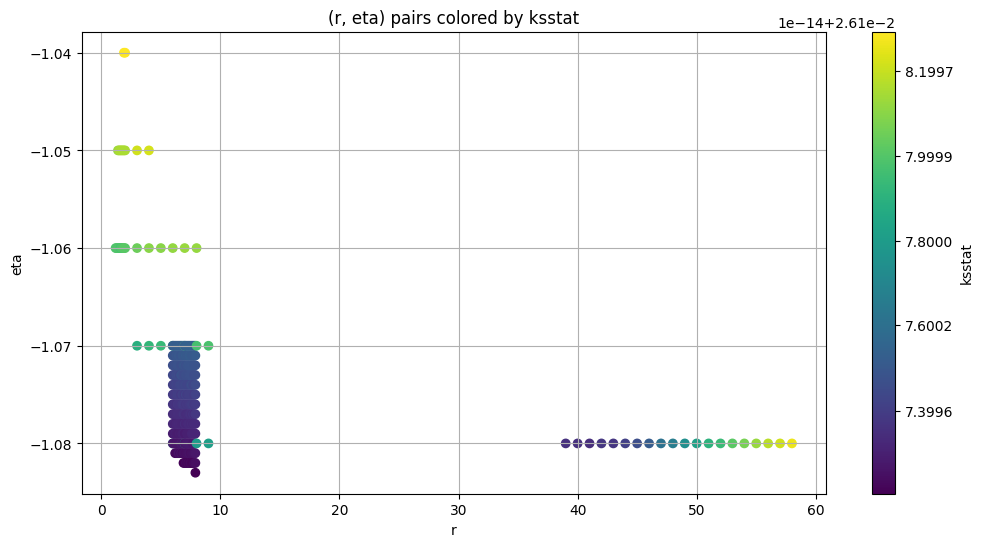

In [ ]:
df = group_cdf_df_dict[10]
min_ksstat = df['ksstat'].min()
max_pval = df['kstest_pval'].max()
eps = 0.0000000001
filtered_df = df[df['ksstat'] < min_ksstat + eps]
print(filtered_df.shape)
create_scatter_plot(filtered_df, 'ksstat');

####
Layer  10


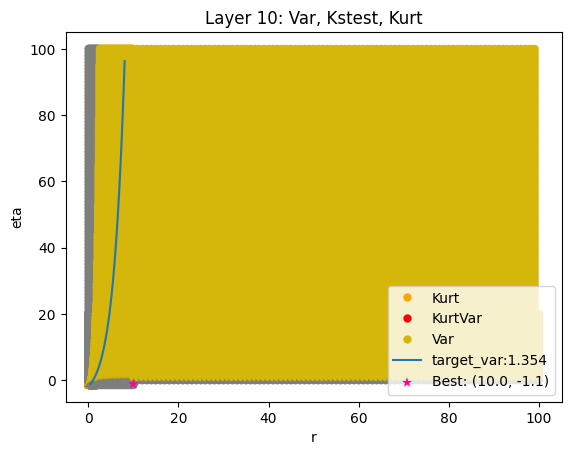

In [ ]:
for i, group in enumerate(GROUPS):
    print(f"####\n{GROUP.capitalize()} ", group)
    cols = ['pass_var', 'pass_kstest', 'pass_kurt']
    fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = master_df.loc[group, 'obs_var'],
                            best_param = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']))
    fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

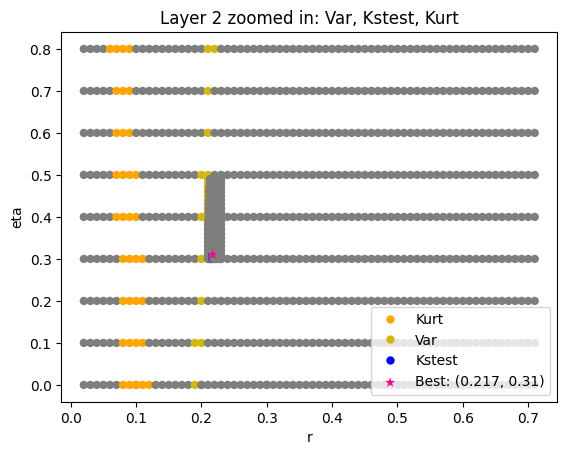

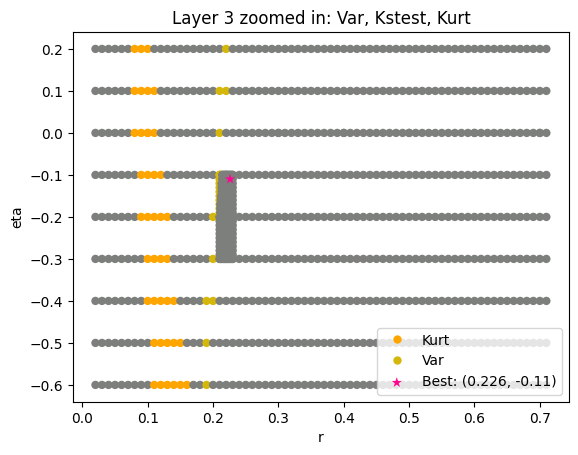

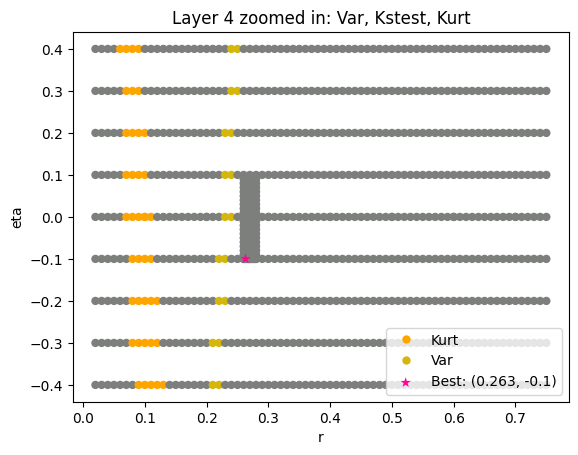

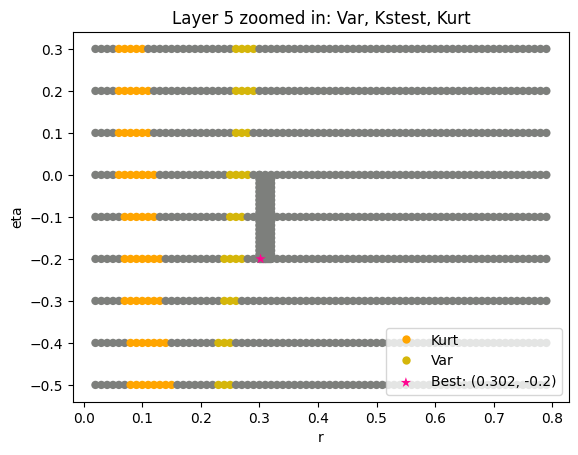

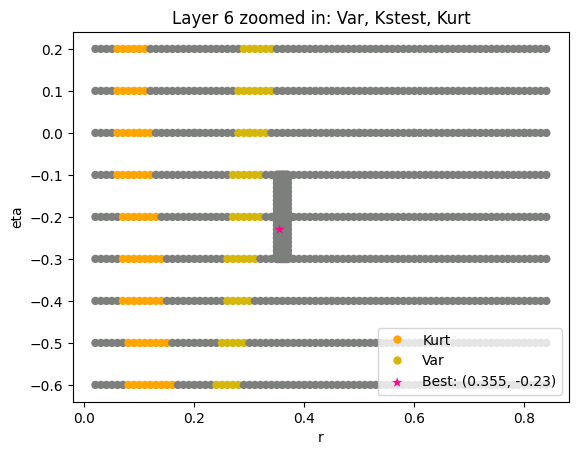

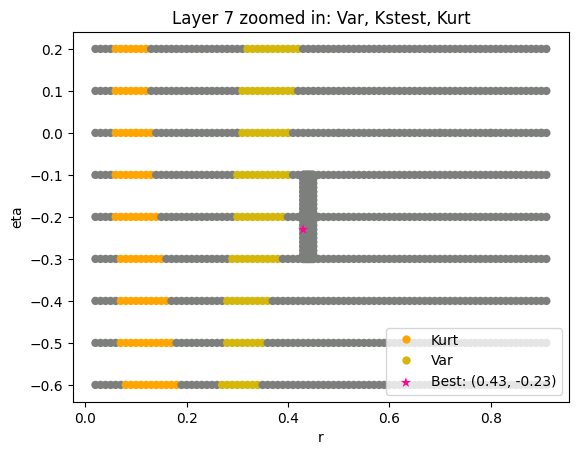

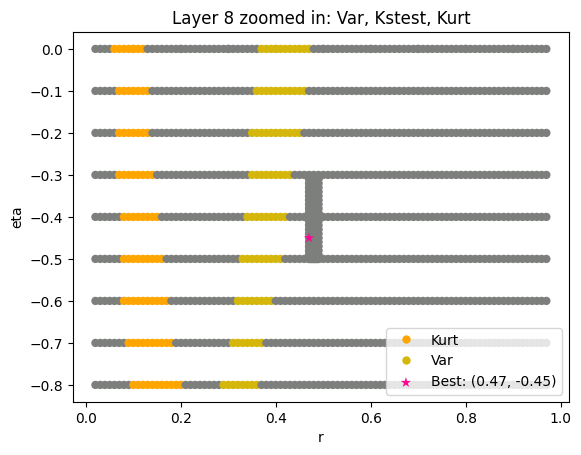

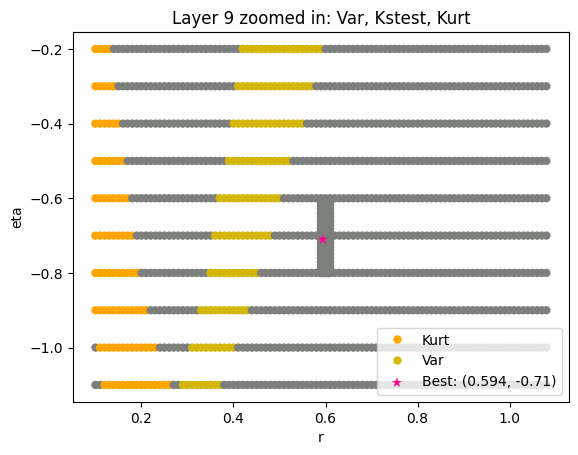

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\plotting.py:38: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


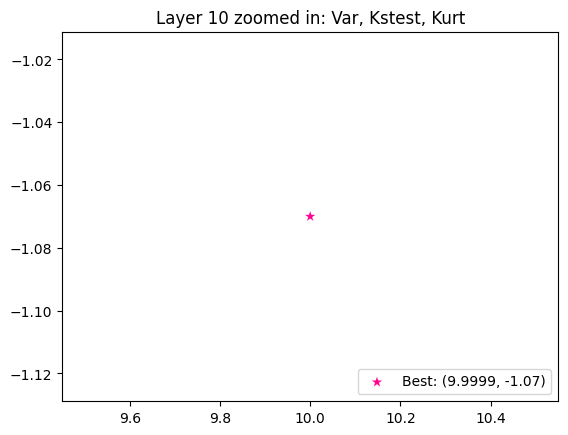

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,150199.610000,85008.824102,248364.732266,411.567795,85.166882,581.245881,9000.0,0.22,0.4,0.017328,...,126.386000,0.053287,1.188320e-22,112.080000,0.027644,2.081510e-06,88.349400,0.024432,4.239170e-05,6.077500e-02
3,33515.562000,19958.825879,52689.479258,366.283332,101.325688,561.984535,36000.0,0.22,-0.2,0.015524,...,51.097400,0.057075,2.235480e-102,45.218000,0.030592,1.054640e-29,35.563000,0.028171,2.979370e-25,2.954800e-06
4,8690.716000,4650.655151,15441.937554,584.811266,124.448718,1337.453648,144000.0,0.27,0.0,0.014394,...,21.927100,0.052141,0.000000e+00,19.615600,0.027260,2.143050e-93,15.331800,0.022689,7.963070e-65,1.200500e-20
5,1600.961900,772.053137,3722.834314,1309.721219,95.400870,3193.442929,576000.0,0.31,-0.1,0.012362,...,10.281000,0.046289,0.000000e+00,9.169130,0.022133,1.499790e-245,7.236210,0.015874,1.665910e-126,7.520700e-56
6,339.519200,152.123086,1059.839684,2687.210297,93.111475,4763.505439,2304000.0,0.36,-0.2,0.007668,...,5.464020,0.038784,0.000000e+00,4.855720,0.015043,0.000000e+00,3.837820,0.009457,2.077520e-179,3.834000e-97
7,87.086320,35.836773,371.805410,4823.475991,72.400958,6356.322824,9216000.0,0.44,-0.2,0.006620,...,3.123040,0.035890,0.000000e+00,2.768430,0.011098,0.000000e+00,2.214910,0.009042,0.000000e+00,7.390800e-234
8,29.883560,15.550574,79.512060,1685.915861,80.564132,3720.926795,36864000.0,0.48,-0.4,0.006882,...,2.034520,0.040489,0.000000e+00,1.797250,0.014289,0.000000e+00,1.433200,0.012347,0.000000e+00,0.000000e+00
9,8.940126,4.773328,23.294833,1591.253639,83.608903,3578.031731,147456000.0,0.60,-0.7,0.008517,...,1.019810,0.043489,0.000000e+00,0.905438,0.018283,0.000000e+00,0.715500,0.014077,0.000000e+00,0.000000e+00
10,1.353995,0.687269,4.314199,2561.703720,78.230434,4657.250795,589824000.0,10.00,-1.1,0.029303,...,0.370727,0.044892,0.000000e+00,0.329689,0.020144,0.000000e+00,0.259616,0.015220,0.000000e+00,0.000000e+00


In [6]:
for group in GROUPS: 
    temp_df = group_cdf_df_dict[group]
    eps = 0.5
    filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                    (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                    (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                    (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
    
    cols = ['pass_var', 'pass_kstest', 'pass_kurt']
    fig = combo_test_plot(filtered_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                            best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
    fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

master_df

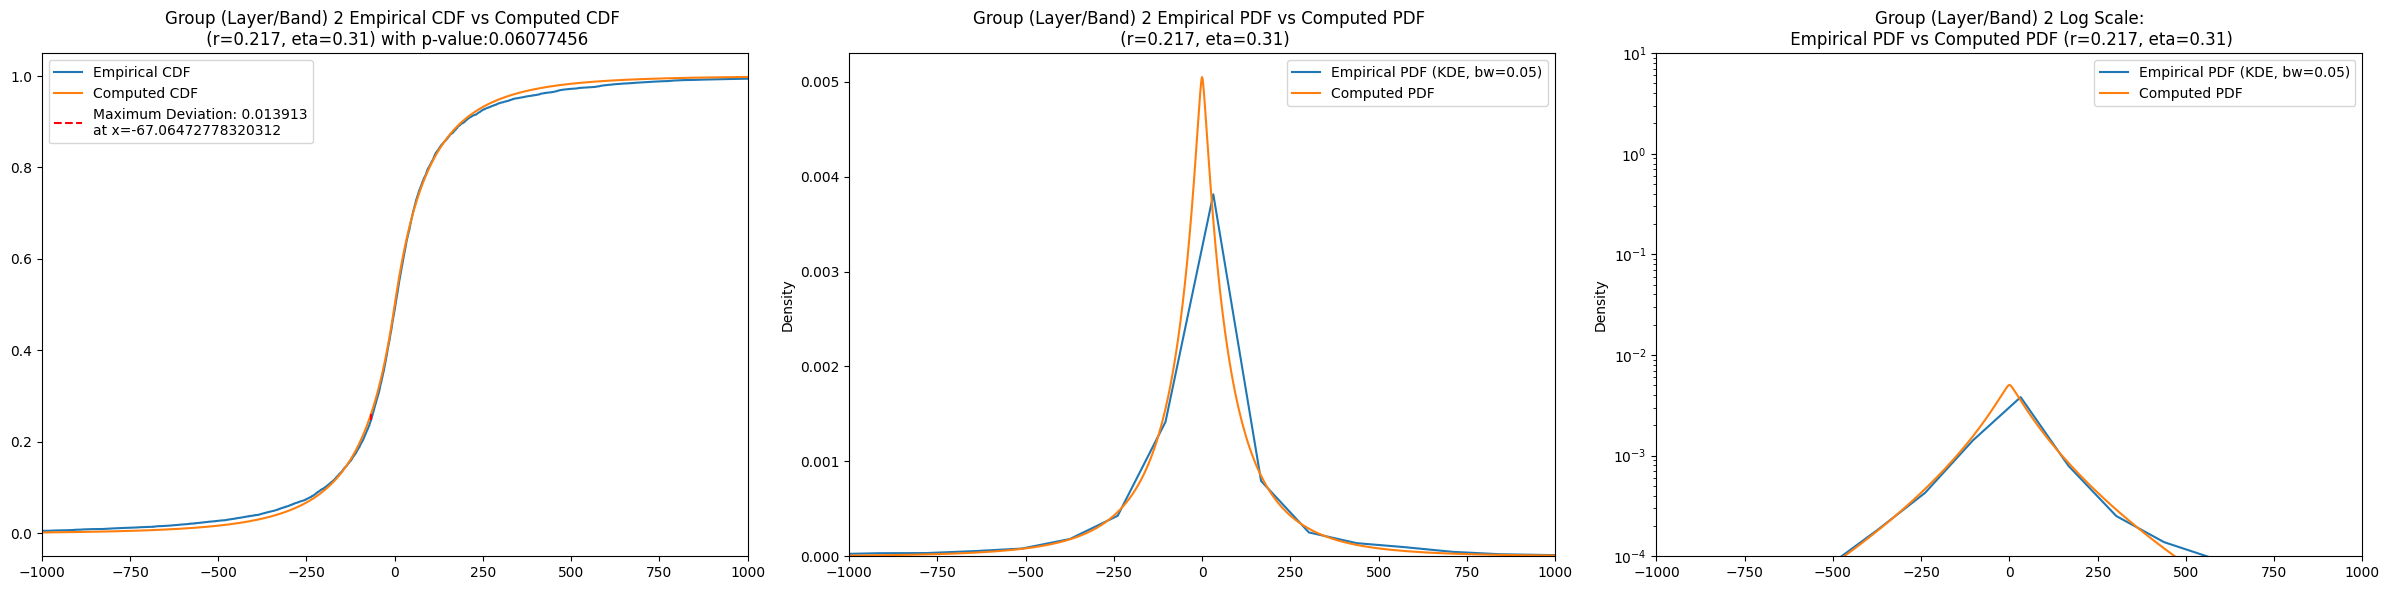

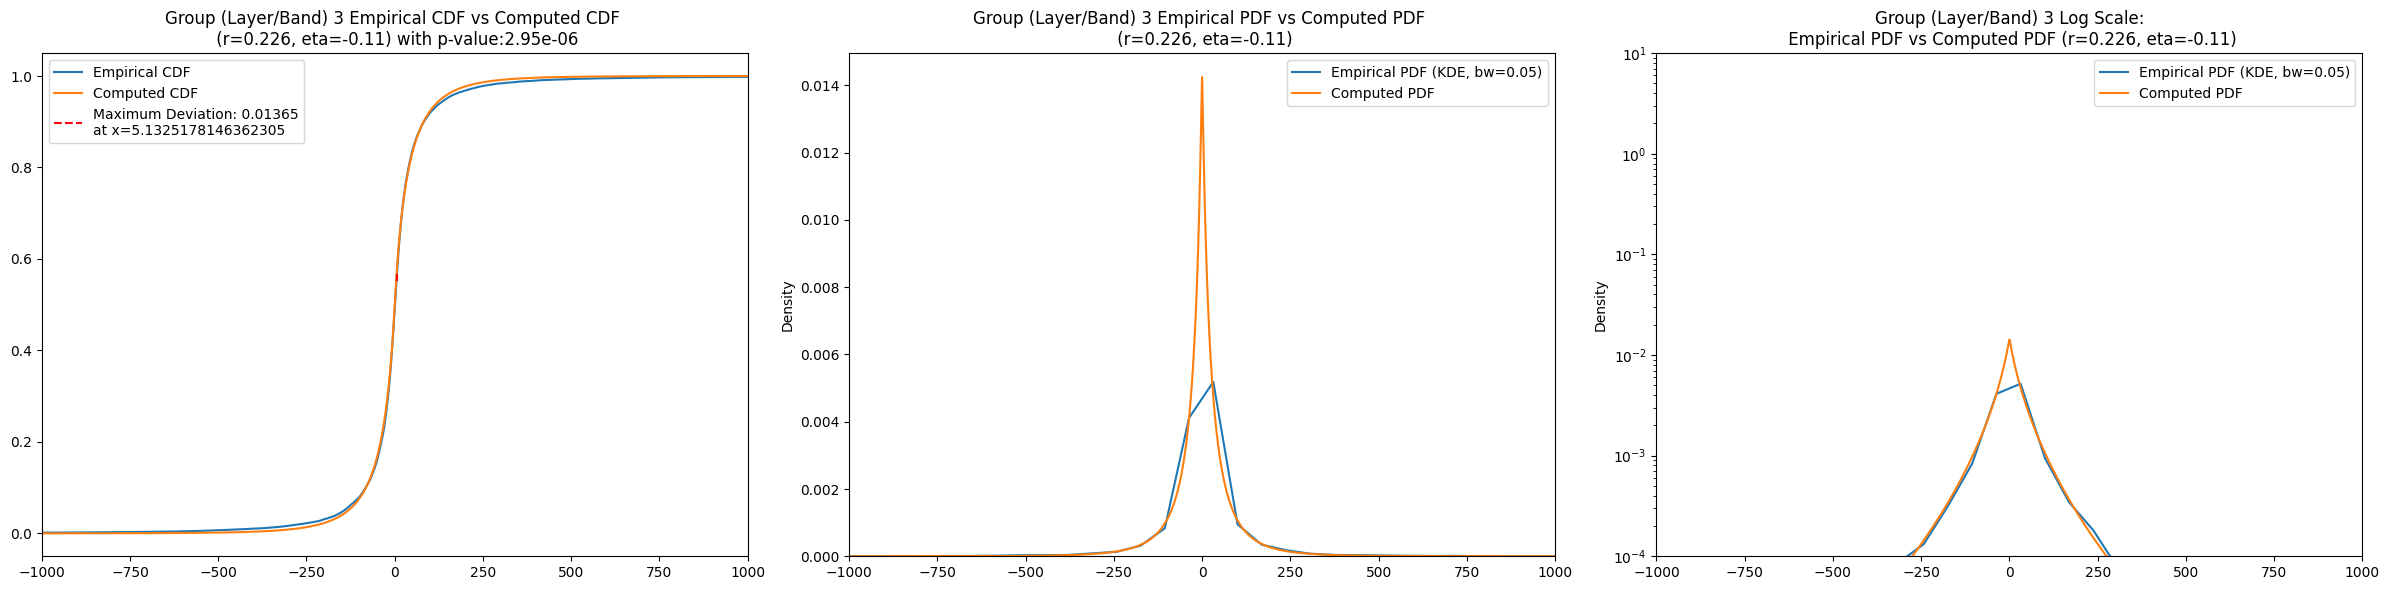

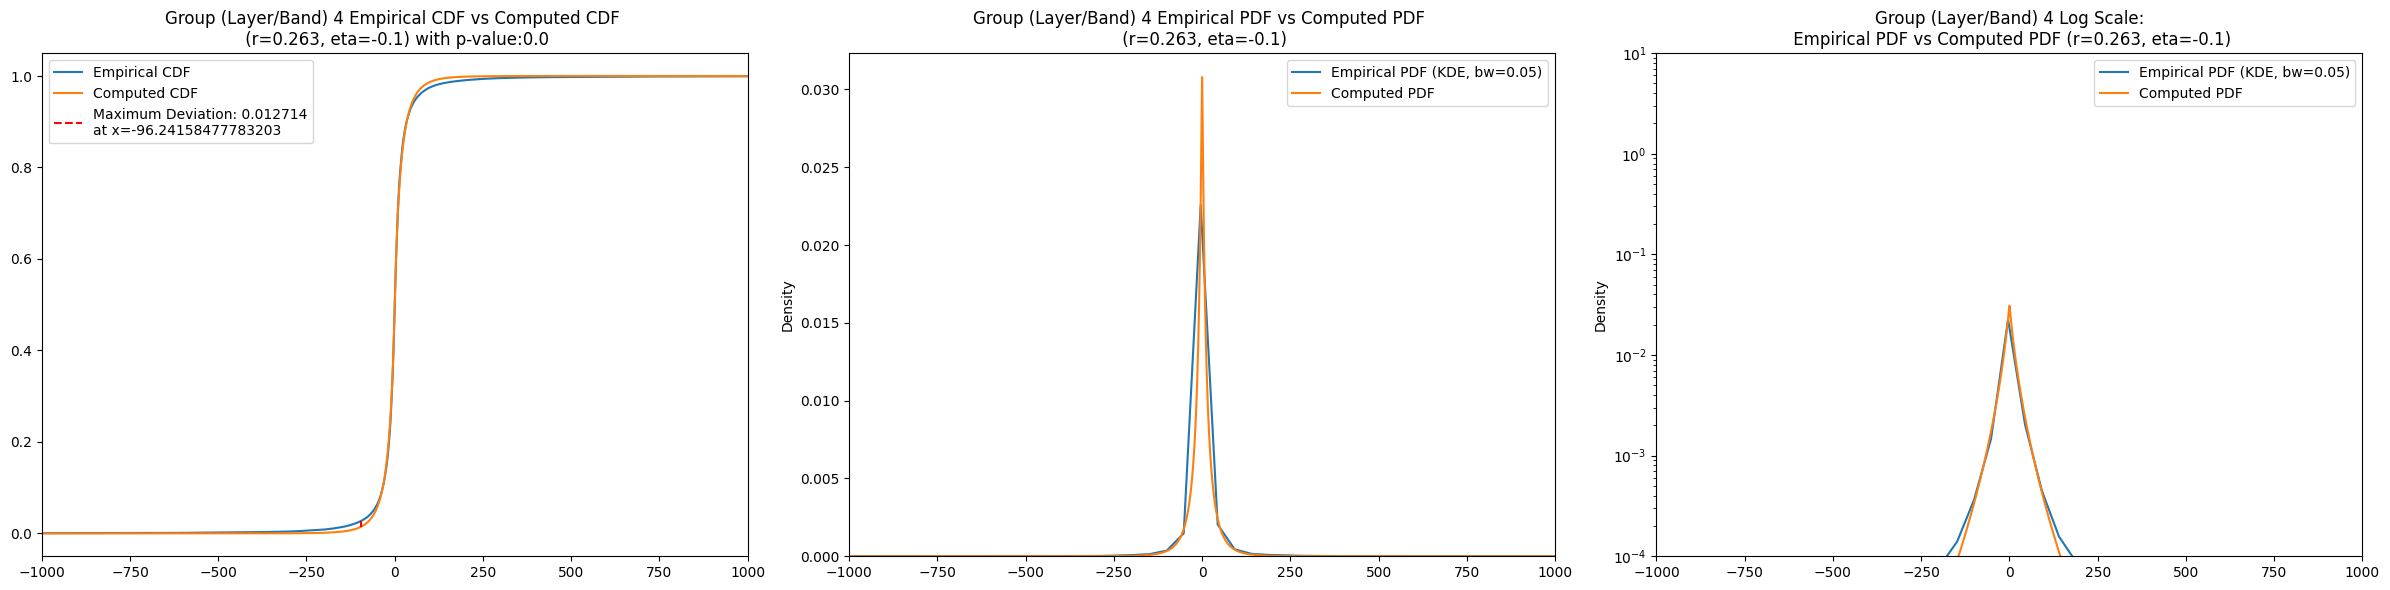

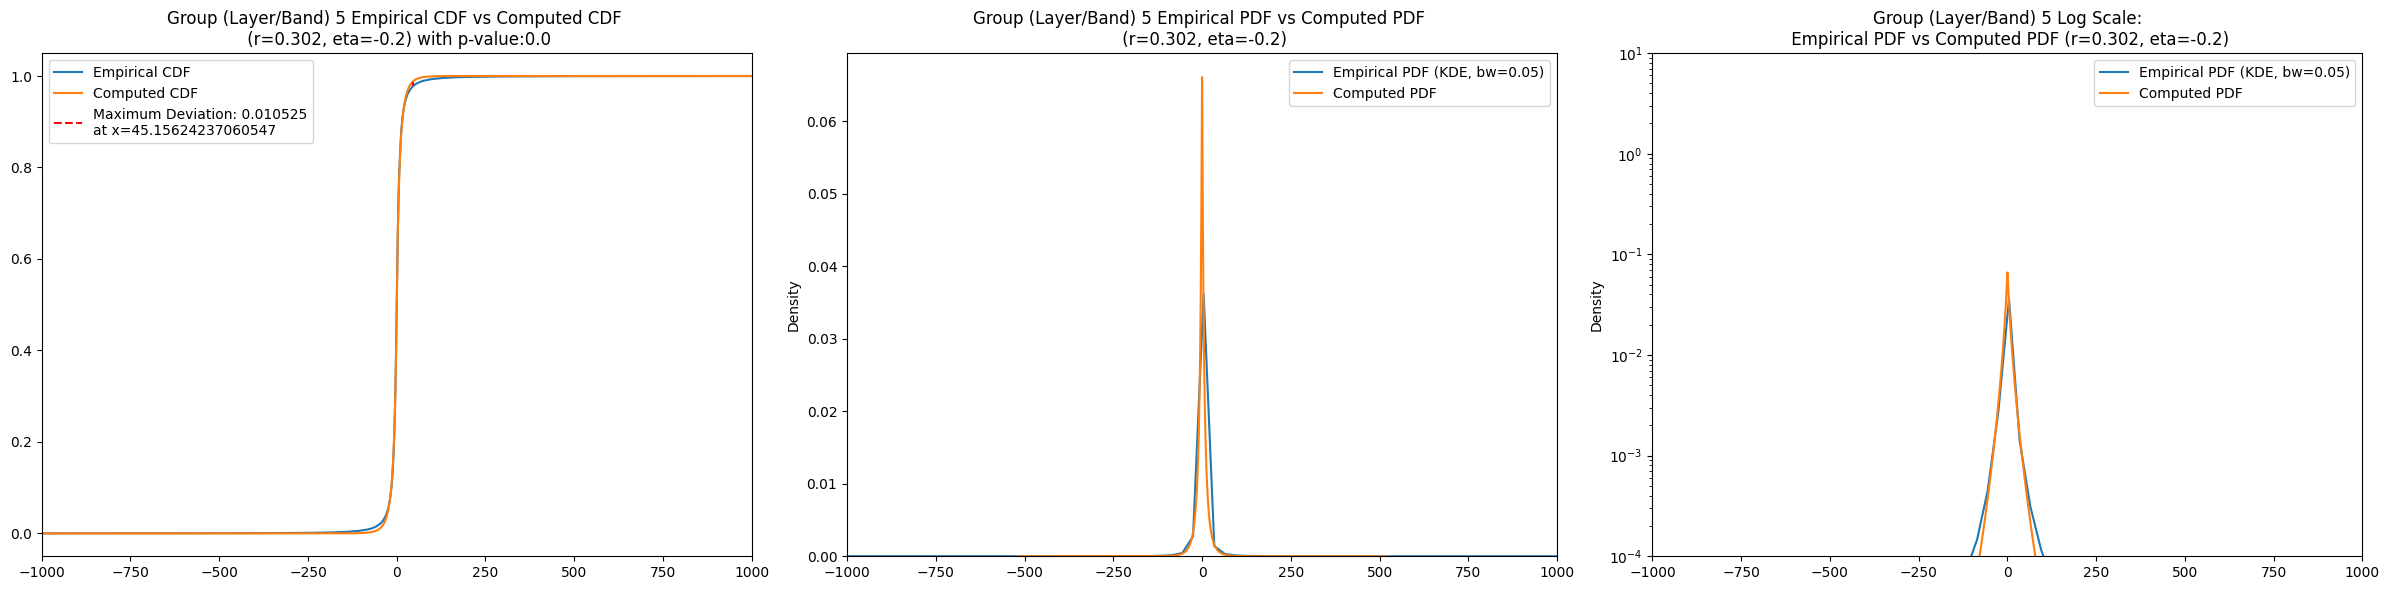

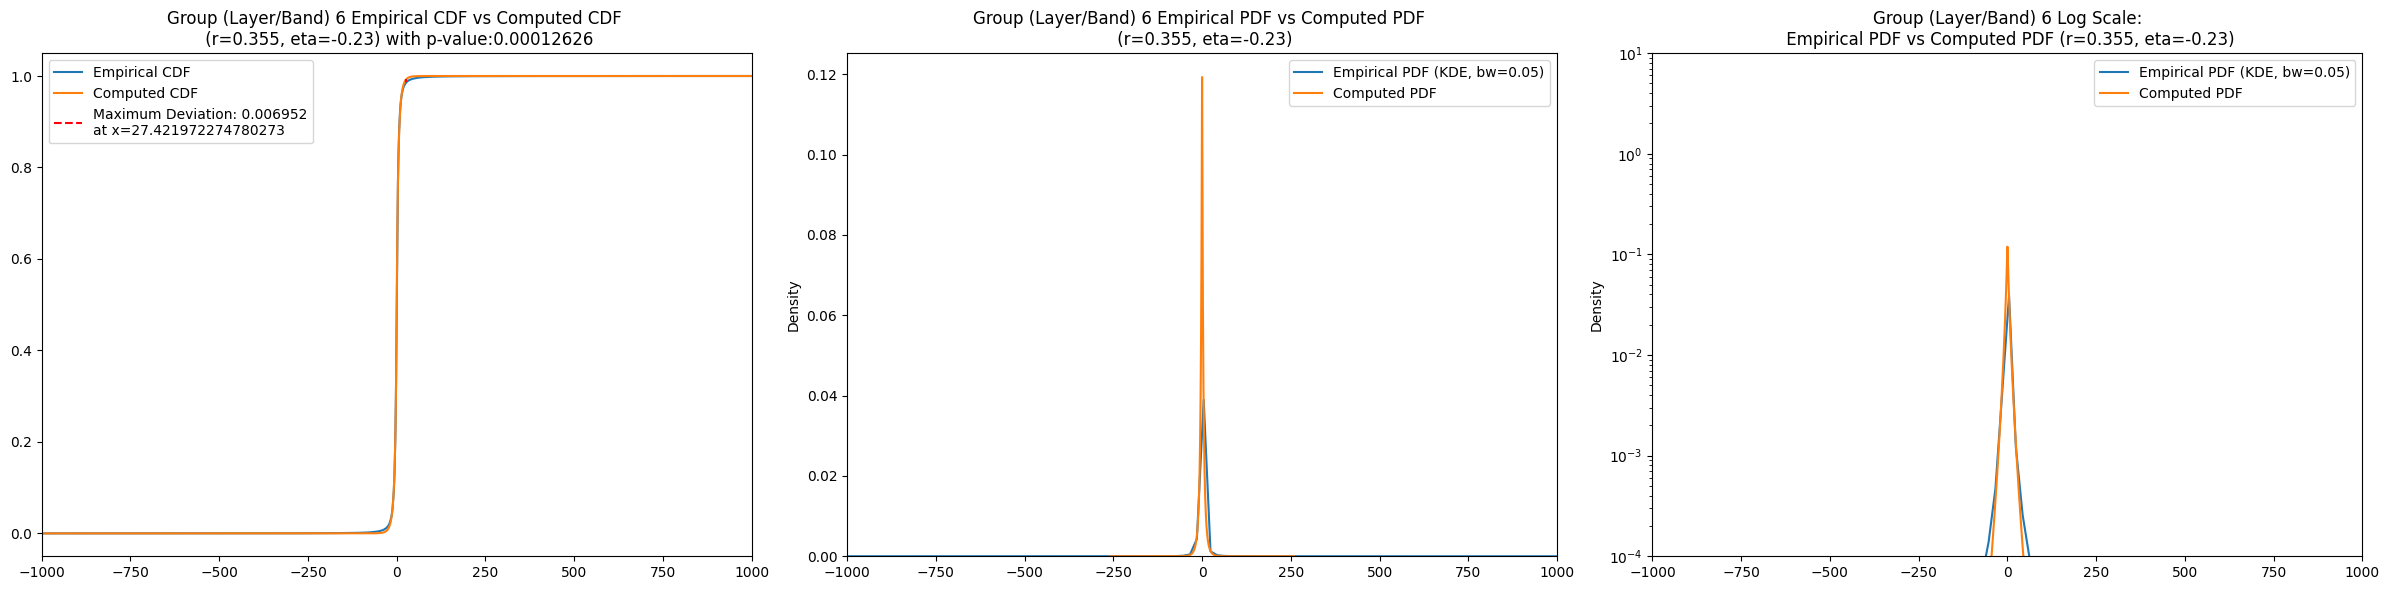

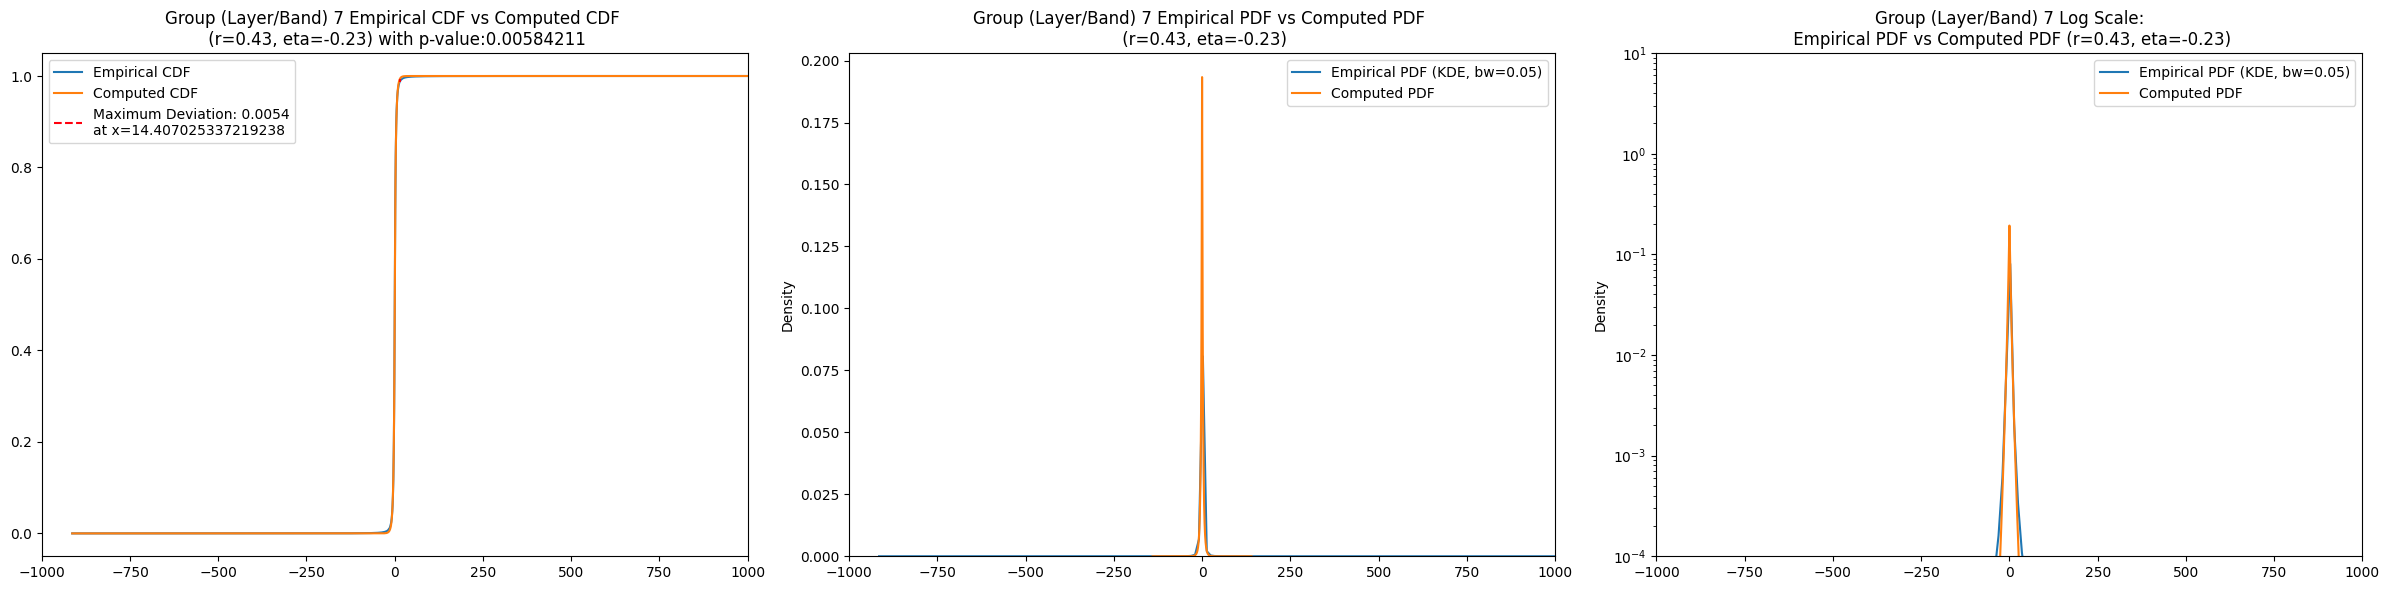

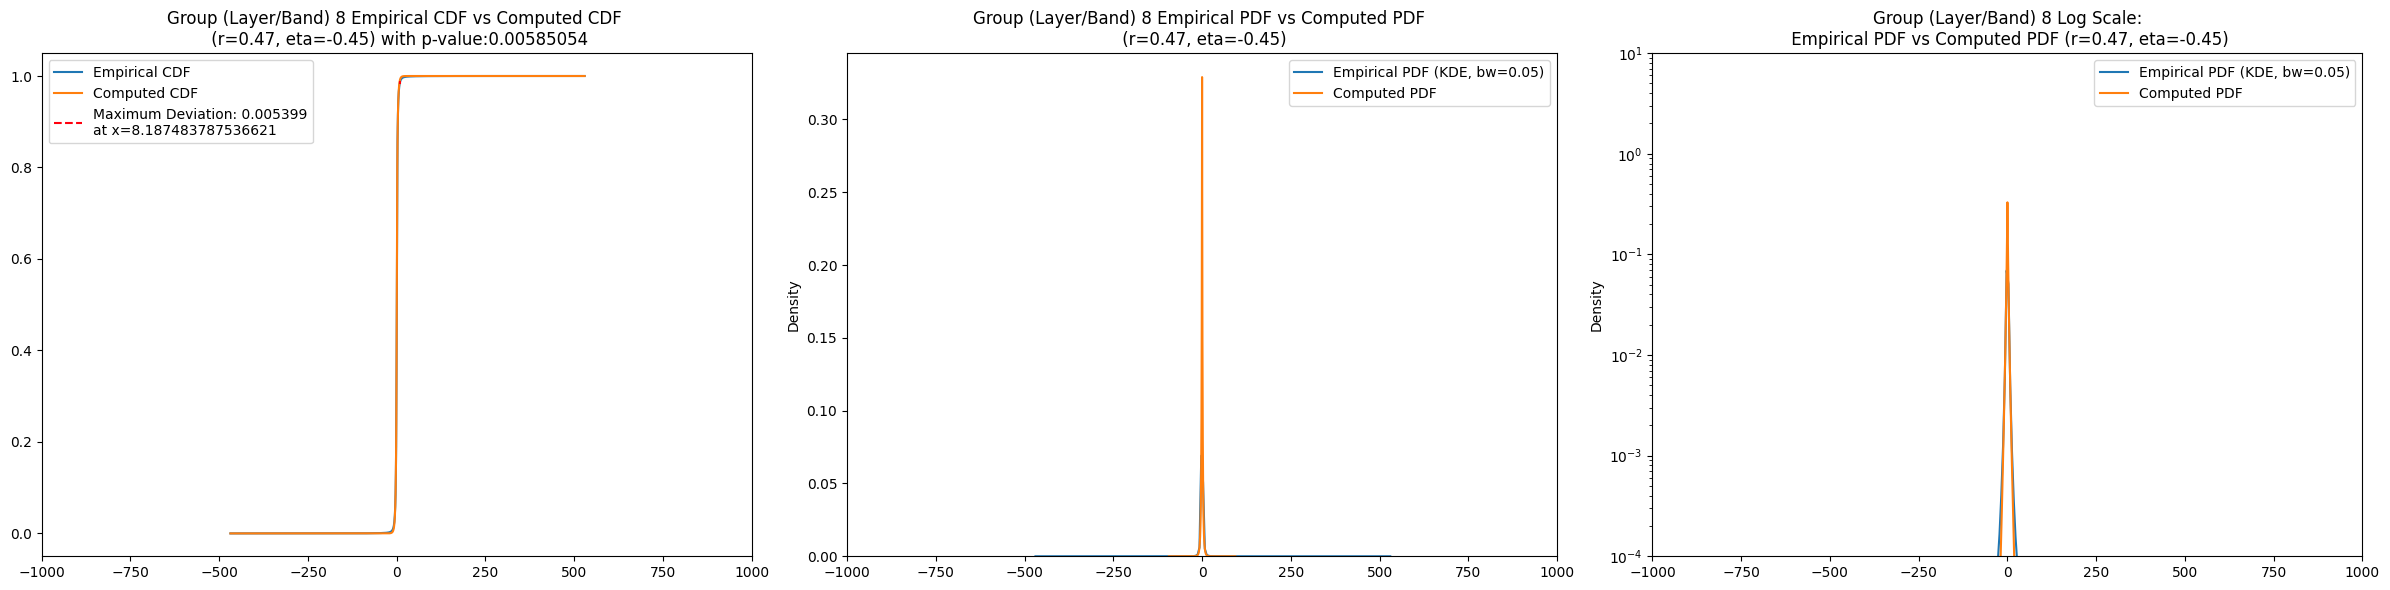

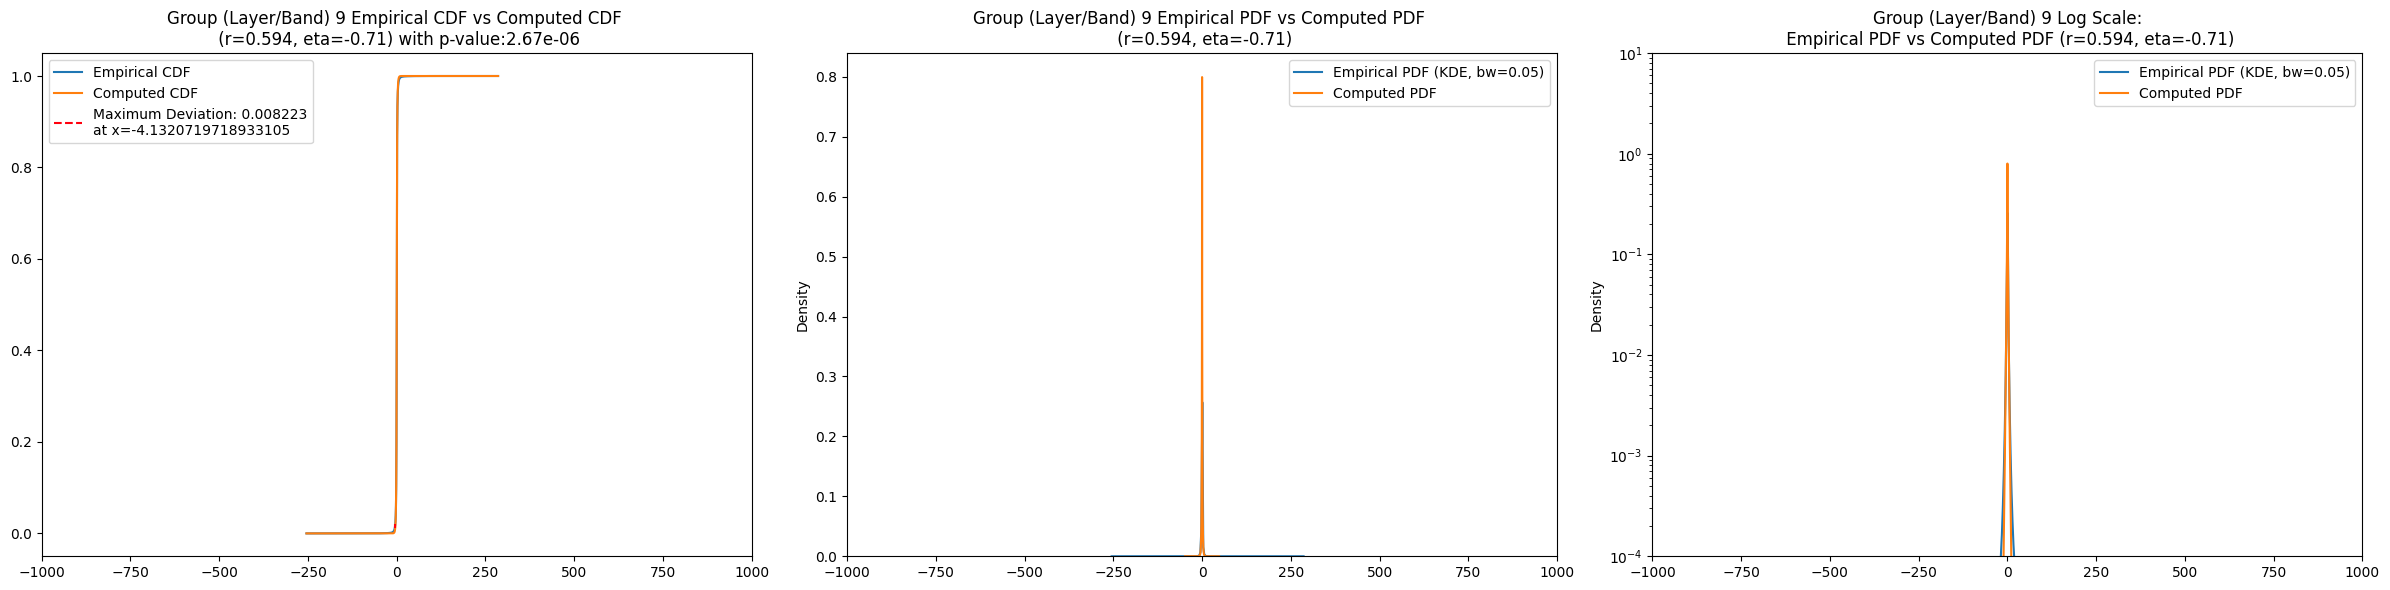

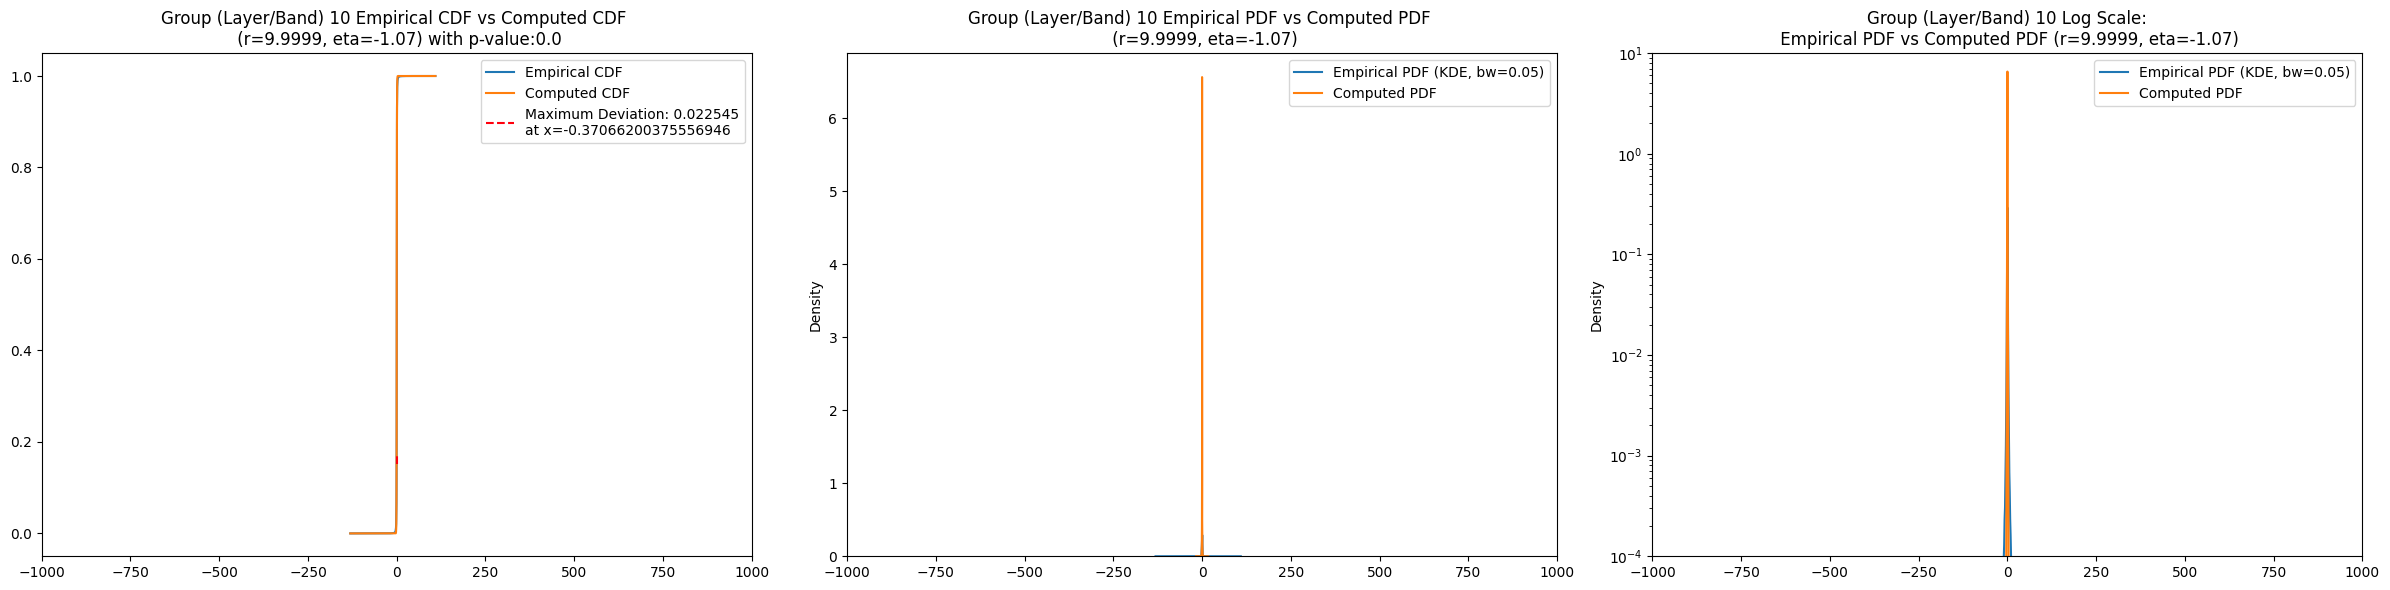

In [ ]:
for group in GROUPS:
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (master_df.loc[group]['best_r'], master_df.loc[group]['best_eta']), 
                    log_scale = True,
                    group = group,
                    interval = (-1000, 1000))
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)